In [2]:
import os
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import datasets # CIFAR10, MNIST
import pytorch_lightning as pl

import matplotlib.pyplot as plt

## CIFAR-10 dataset. 
The dataset contains 10 classes and has 60.000 32 by 32 pixel images, with 6000 images per class.

ds_cifar = datasets.CIFAR10(
    '../data/cifar10', 
    download=True, 
    transform=transforms.ToTensor())

In [ ]:
# Load data set
t_mnist = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0), std=(1))]
                       )

ds_mnist_train = datasets.MNIST(
    '../data/mnist', 
    download=True, 
    train=True, 
    transform=transforms.ToTensor())
ds_mnist_test = datasets.MNIST(
    '../data/mnist', 
    download=True, 
    train=False, 
    transform=transforms.ToTensor())



In [27]:
ds_fashion_train = datasets.FashionMNIST(
    root="../data/fashionmnist",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

ds_fashion_test = datasets.FashionMNIST(
    root="../data/fashionmnist",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

0it [00:00, ?it/s]

Extracting ../data/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ../data/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

# Selecting and Visualizing Dataset

In [ ]:
ds_train = ds_mnist_train
ds_test = ds_mnist_test
ds_train

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data/mnist
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=0, std=1)
                         )
    Target Transforms (if any): None

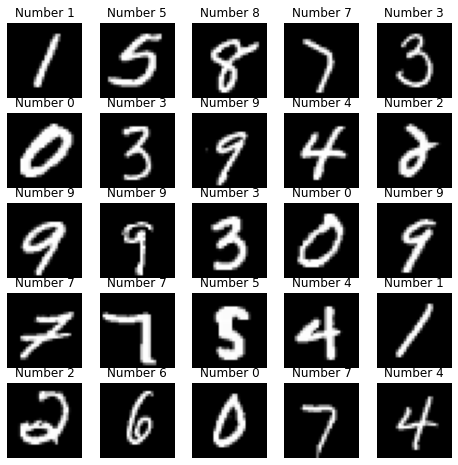

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(ds_train.data.shape[0], size=(1,)).item()

    img = ds_train.data[sample_idx]
    label = ds_train.targets[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title('Number {}'.format(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

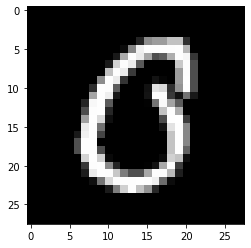

In [15]:
image = ds_train.data[234]
plt.imshow(image.squeeze(), cmap="gray")

## Data loader

In [ ]:
# Prepare training data loader

batch_size=10

loaders = {
    'train' : torch.utils.data.DataLoader(ds_train, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(ds_test, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.9/site-packages/torchvision/datasets/mnist.py", line 95, in __getitem__
    img = self.transform(img)
  File "/opt/conda/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 60, in __call__
    img = t(img)
  File "/opt/conda/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 163, in __call__
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/opt/conda/lib/python3.9/site-packages/torchvision/transforms/functional.py", line 208, in normalize
    tensor.sub_(mean[:, None, None]).div_(std[:, None, None])
IndexError: too many indices for tensor of dimension 0


In [13]:
# pytorch

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(32 * 32 * 3, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [14]:
if __name__ == '__main__':
  
  # Set fixed random number seed
  torch.manual_seed(42)
  

  
  # Initialize the MLP
  mlp = MLP()
  
  # Define the loss function and optimizer
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
  
  # Run the training loop
  for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

  # Process is complete.
  print('Training process has finished.')

Starting epoch 1


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.9/site-packages/torchvision/datasets/mnist.py", line 95, in __getitem__
    img = self.transform(img)
  File "/opt/conda/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 60, in __call__
    img = t(img)
  File "/opt/conda/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 163, in __call__
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/opt/conda/lib/python3.9/site-packages/torchvision/transforms/functional.py", line 208, in normalize
    tensor.sub_(mean[:, None, None]).div_(std[:, None, None])
IndexError: too many indices for tensor of dimension 0


In [11]:
# https://www.machinecurve.com/index.php/2021/01/26/creating-a-multilayer-perceptron-with-pytorch-and-lightning/

class MLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(32 * 32 * 3, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )
    self.ce = nn.CrossEntropyLoss()
    
  def forward(self, x):
    return self.layers(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    y_hat = self.layers(x)
    loss = self.ce(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    return optimizer

In [4]:
if __name__ == '__main__':
  dataset = CIFAR10(os.getcwd(), download=True, transform=transforms.ToTensor())
  pl.seed_everything(42)
  mlp = MLP()
  trainer = pl.Trainer(auto_scale_batch_size='power', gpus=0, deterministic=True, max_epochs=5)
  trainer.fit(mlp, DataLoader(dataset))

Files already downloaded and verified


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type             | Params
--------------------------------------------
0 | layers | Sequential       | 199 K 
1 | ce     | CrossEntropyLoss | 0     
--------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.796     Total estimated model params size (MB)
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
